## ML Supervisado: Clasificaciones - Tarea Individual

### Entrega 30/12 a correo marcelo.medel.v@gmail.com.

(50%) Desarrolle un modelo utilizando los datos con SMOTE Oversampling.
* Utilizar de entrenamiento variables **x_smote, y_smote**
* Escoja el modelo que mejor se ajustó a sus datos sin oversampling.
* Realice una comparación de los resultados entre el modelo **con oversampling** y el mejor modelo obtenido con los datos **sin oversampling**. Interprete los resultados.
* Para el objetivo específico que queremos solucionar (identificar transacciones fraudulentas dado el perjuicio que puede representar esto para los clientes), ¿cuál modelo entrega una mejor solución? ¿por qué ese modelo es mejor?.

(50%) Utilizando XGBoost:
* Realice una optimización de los hiperparámetros del modelo utilizando GridSearchCV o RandomSearchCV.
* ¿Cuáles son los valores de los hiperparámetros del mejor modelo obtenido?.
* Compare el modelo obtenido con la optimización de hiperparámetros vs el modelo por default (hiperparámetros por defecto incluidos en la librería), ¿qué mejoras logra observar basándose en las métricas?.

## Classification Example

* Ejemplo tomado de kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
#Importing librairies
import pandas as pd 
import numpy as np

# Matplotlib library to plot the charts
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Data preprocessing

* Se carga el archivo creditcard.csv
* Las 28 variables (V1-->V28) corresponden el resultado de una reducción de dimensionalidad de los datos originales utilizando **PCA**. Por lo que no requiere un tratamiento especial de los datos.
* La variable Amount tiene una distribución positivamente sesgada (es decir los valores están mas agrupados cercanos al 0).
* Se realiza un escalamiento (con standard scaler) de la variable Amount
* Class = 1 indica Fraude.

In [2]:
data = pd.read_csv('data/creditcard.csv')
data.head()

#url = 'https://drive.google.com/file/d/1OnD5PMOSoq9iUDe-IYh1rtQ_L08uJl3H/view?usp=drive_link'
#path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
#df = pd.read_csv(path, sep=";", encoding="ISO-8859-1", header=0, compression='zip')
#df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


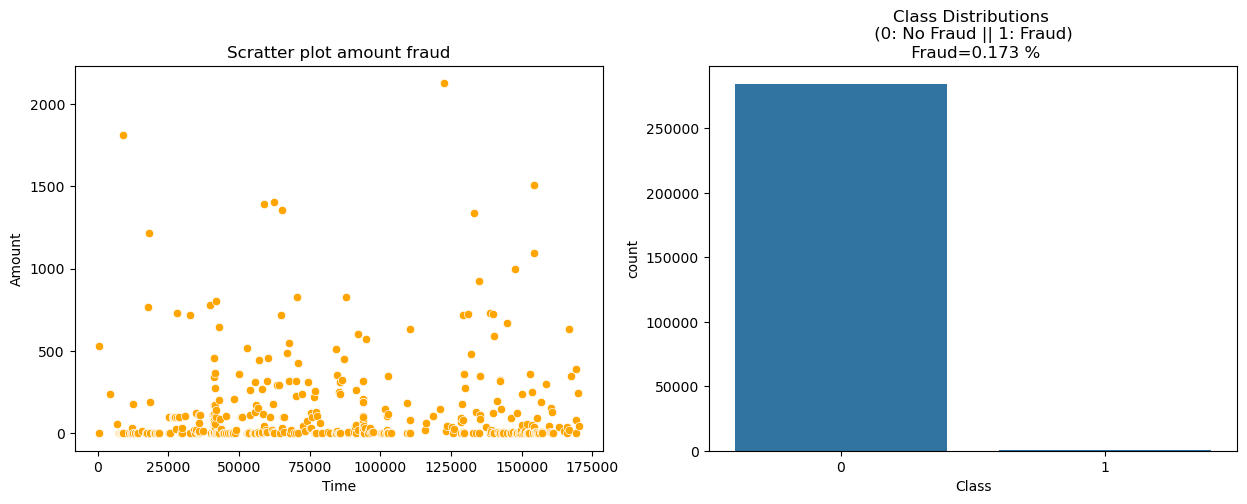

In [3]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

#plt.figure(figsize=(8,5))
sns.scatterplot(x=data.query("Class==1")['Time'], y=data.query("Class==1")['Amount'],color='orange',ax=ax[0])
ax[0].set_title('Scratter plot amount fraud')
#plt.xlabel('Time')
#plt.ylabel('Amount')

sns.countplot(x='Class', data=data,ax=ax[1])
p_fraud = round(100*(data.query("Class==1").shape[0]/data.shape[0]),3)
ax[1].set_title(f'Class Distributions \n (0: No Fraud || 1: Fraud) \n Fraud={p_fraud} %', fontsize=12)
plt.show()

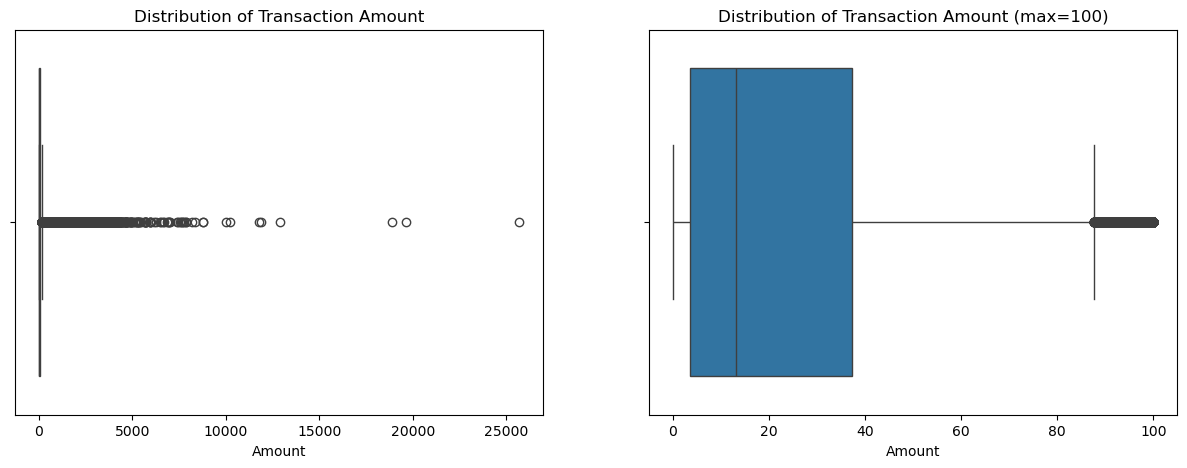

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(x=data.Amount,ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount', fontsize=12)
sns.boxplot(x=data.query("Amount <= 100").Amount,ax=ax[1])
ax[1].set_title('Distribution of Transaction Amount (max=100)', fontsize=12)
plt.show()

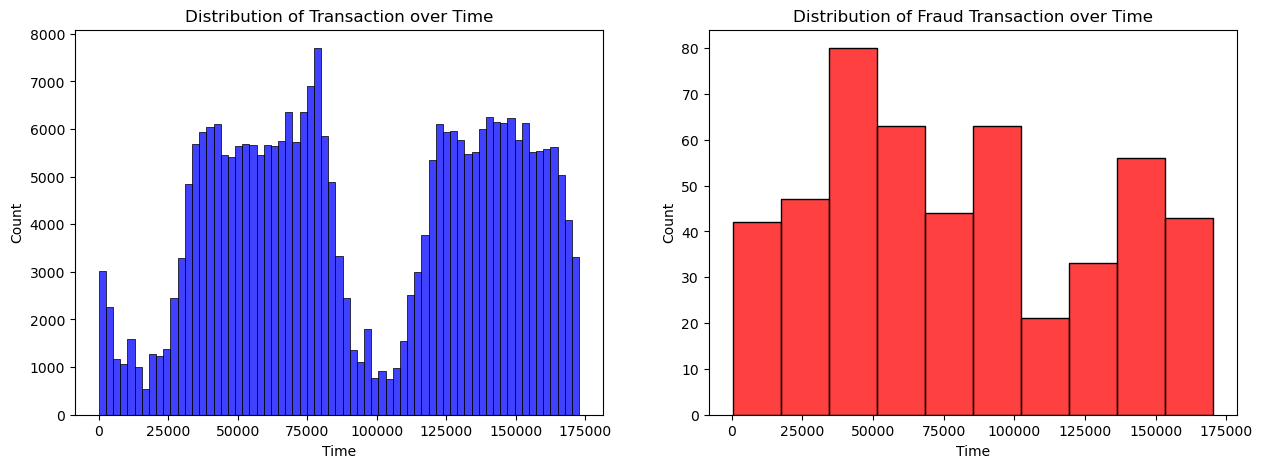

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.histplot(x=data.Time, color='b',ax=ax[0])
ax[0].set_title('Distribution of Transaction over Time', fontsize=12)

sns.histplot(x=data.query("Class==1").Time, color='r',ax=ax[1])
ax[1].set_title('Distribution of Fraud Transaction over Time', fontsize=12)

plt.show()

In [6]:
#for standardising data
from sklearn.preprocessing import StandardScaler 
scaler=StandardScaler()

data['amount_scaled'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,amount_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160686
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.140534
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073403


### Train / test split process

* Para poder entrenar el modelo se dividen los datos en entrenamiento (70%) y test (30%).
* Se definen las variables independientes (**X**): [*V1 --> V28*] + *amount_scaled*
* Se define la variable dependiente (**Y**): *Class*.

In [7]:
from sklearn.model_selection import train_test_split

X = data.drop(['Class','Amount','Time'], axis = 1).values
Y = data['Class'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y ,test_size=0.3, random_state=13)

### Métricas 

Vamos a medir las métricas clásicas de problemas de clasificación:
* Miraremos la matriz de confusión para entender las métricas
* Accuracy, Precision, Recall, f1-score
* Revisión del AUC Score

In [8]:
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix


def get_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test,y_pred, average='macro')
    c_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    
    
    return {'accuracy':accuracy,'precision':precision,'recall':recall,'f1score':f1score} , c_matrix


### Modelos

Se desarrolla el ejemplo con los siguientes modelos:
* Decision Tree Classifier
* Random Forest Classifier
* AdaBoost Classifier
* Gradient Boosting Classifier
* XGBoost Classifier


In [10]:
models_metrics = {}
models_cm = {}

In [11]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=3
)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
model_name = 'DecisionTree'
models_metrics[model_name], models_cm[model_name] = get_metrics(y_test, y_pred)

In [12]:
%%time
from sklearn.ensemble import RandomForestClassifier

modelRF = RandomForestClassifier(random_state=13)
modelRF.fit(x_train, y_train)
y_pred = modelRF.predict(x_test)
model_name = 'RandomForest'
models_metrics[model_name], models_cm[model_name]  = get_metrics(y_test,y_pred)

CPU times: user 2min 26s, sys: 840 ms, total: 2min 27s
Wall time: 2min 32s


In [13]:
%%time
from sklearn.ensemble import AdaBoostClassifier

modelAda = AdaBoostClassifier(random_state=13)
modelAda.fit(x_train, y_train)
y_pred = modelAda.predict(x_test)
model_name = 'AdaBoost'
models_metrics[model_name], models_cm[model_name]  = get_metrics(y_test,y_pred)

/Users/marcelomedel/opt/anaconda3/envs/de-ml/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


CPU times: user 43.5 s, sys: 295 ms, total: 43.8 s
Wall time: 44.2 s


In [14]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

modelGB = GradientBoostingClassifier(random_state=13)
modelGB.fit(x_train, y_train)
y_pred = modelGB.predict(x_test)
model_name = 'GradientBoosting'
models_metrics[model_name], models_cm[model_name]  = get_metrics(y_test,y_pred)

CPU times: user 3min 35s, sys: 1.66 s, total: 3min 36s
Wall time: 3min 40s


In [15]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 264.4 kB/s eta 0:00:00a 0:00:02


In [16]:
%%time
from xgboost import XGBClassifier

modelXGB = XGBClassifier(random_state=13)
modelXGB.fit(x_train, y_train)
y_pred = modelXGB.predict(x_test)
model_name = 'XGBoost'
models_metrics[model_name], models_cm[model_name]  = get_metrics(y_test,y_pred)

CPU times: user 6.17 s, sys: 1.01 s, total: 7.18 s
Wall time: 6.19 s


In [17]:
df_metrics = pd.DataFrame.from_dict(models_metrics)
df_metrics

,DecisionTree,RandomForest,AdaBoost,GradientBoosting,XGBoost
accuracy,0.999415,0.999544,0.999216,0.999263,0.999614
precision,0.870690,0.953271,0.834951,0.861386,0.972477
recall,0.742647,0.750000,0.632353,0.639706,0.779412
f1score,0.900647,0.919639,0.859636,0.866904,0.932556


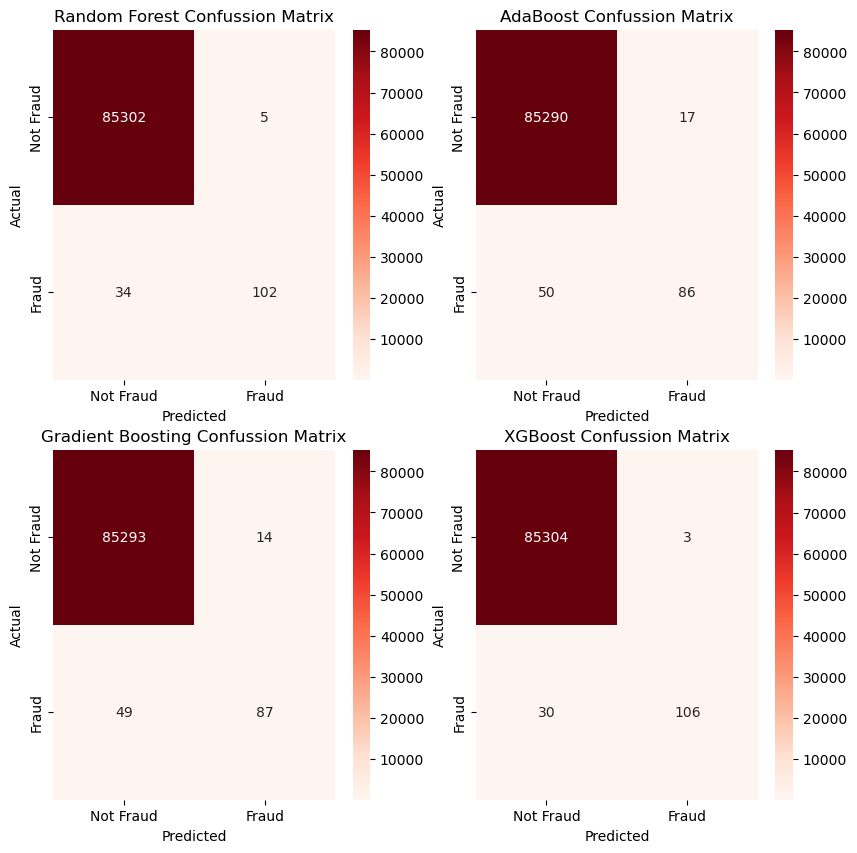

CPU times: user 858 ms, sys: 172 ms, total: 1.03 s
Wall time: 530 ms


In [18]:
%%time
fig, ax = plt.subplots(2,2,figsize=(10,10))


c_matrix = models_cm['RandomForest']
sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="Reds" ,fmt='g',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud']
           ,ax=ax[0,0])
ax[0,0].set_title('Random Forest Confussion Matrix', fontsize=12)


c_matrix = models_cm['AdaBoost']
sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="Reds" ,fmt='g',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud']
           ,ax=ax[0,1])
ax[0,1].set_title('AdaBoost Confussion Matrix', fontsize=12)


c_matrix = models_cm['GradientBoosting']
sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="Reds" ,fmt='g',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud']
           ,ax=ax[1,0])
ax[1,0].set_title('Gradient Boosting Confussion Matrix', fontsize=12)

c_matrix = models_cm['XGBoost']
sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="Reds" ,fmt='g',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud']
           ,ax=ax[1,1])
ax[1,1].set_title('XGBoost Confussion Matrix', fontsize=12)



plt.show()

CPU times: user 3.32 s, sys: 169 ms, total: 3.48 s
Wall time: 2.49 s


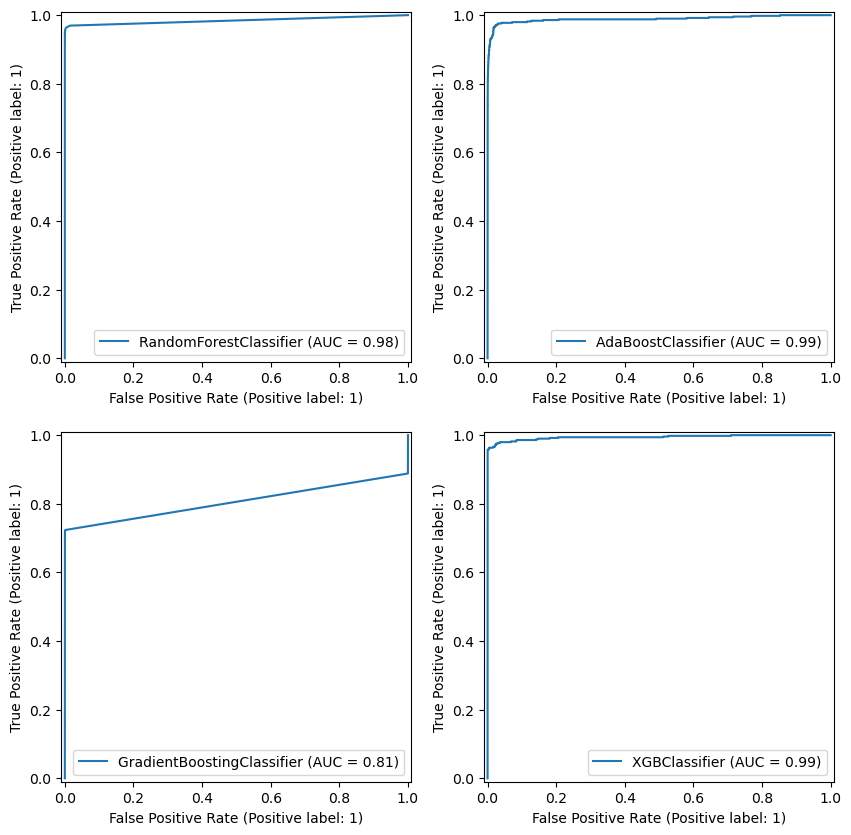

In [19]:
%%time
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(2,2,figsize=(10,10))

RocCurveDisplay.from_estimator(modelRF,X, Y,ax=ax[0,0])
RocCurveDisplay.from_estimator(modelAda,X, Y,ax=ax[0,1])
RocCurveDisplay.from_estimator(modelGB,X, Y,ax=ax[1,0])
RocCurveDisplay.from_estimator(modelXGB,X, Y,ax=ax[1,1])

### Tratamiento de clases desbalanceada

Como sabemos nuestro dataset tienen las clases desbalanceadas, solo el 0,173% de los datos contienen a la clase 1, es decir, son fraude.

En este caso realizaremos over sampling utilizando **SMOTE** --> https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [20]:
!pip install -U imbalanced-learn

In [21]:
%%time
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(sampling_strategy=0.3)
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x_train, y_train)


print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 199008, 1: 356})
Resample dataset shape Counter({0: 199008, 1: 59702})
CPU times: user 378 ms, sys: 386 ms, total: 763 ms
Wall time: 15.9 s


## Optimización de hiperparámetros


Se realiza una optimización de hiperparámetros (n_estimators y max_depth) para el algoritmo de Random Forest Classifier utilizando un **grid search CV** y **random search CV**

In [22]:
%%time
### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=13),
                           param_grid = {'n_estimators':[10,50,100],'max_depth':[5,10,20]},
                           cv=3, 
                           scoring="recall",
                           verbose=2,
                           )
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .......................max_depth=5, n_estimators=10; total time=   2.9s
[CV] END .......................max_depth=5, n_estimators=10; total time=   2.8s
[CV] END .......................max_depth=5, n_estimators=10; total time=   2.9s
[CV] END .......................max_depth=5, n_estimators=50; total time=  14.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=  13.8s
[CV] END .......................max_depth=5, n_estimators=50; total time=  13.7s
[CV] END ......................max_depth=5, n_estimators=100; total time=  28.0s
[CV] END ......................max_depth=5, n_estimators=100; total time=  27.6s
[CV] END ......................max_depth=5, n_estimators=100; total time=  27.7s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.3s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.4s
[CV] END ......................max_depth=10, n_es

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=13),
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [10, 50, 100]},
             scoring='recall', verbose=2)

In [23]:
grid_search.best_params_

{'max_depth': 20, 'n_estimators': 100}

In [24]:
grid_search.best_score_

0.7808716707021791

In [25]:
%%time
### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

randomgrid_search = RandomizedSearchCV(
    estimator = RandomForestClassifier(random_state=13),
    n_iter = 3,
    param_distributions = {'n_estimators':[10,50,100],'max_depth':[5,10,20]},
    cv=3,
    scoring="recall",
    verbose=2
)
randomgrid_search.fit(x_train,y_train)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .......................max_depth=5, n_estimators=10; total time=   2.8s
[CV] END .......................max_depth=5, n_estimators=10; total time=   2.8s
[CV] END .......................max_depth=5, n_estimators=10; total time=   2.8s
[CV] END ......................max_depth=20, n_estimators=10; total time=   7.2s
[CV] END ......................max_depth=20, n_estimators=10; total time=   7.1s
[CV] END ......................max_depth=20, n_estimators=10; total time=   7.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=  52.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=  52.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=  52.8s
CPU times: user 4min 26s, sys: 1.05 s, total: 4min 27s
Wall time: 4min 29s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=13),
                   n_iter=3,
                   param_distributions={'max_depth': [5, 10, 20],
                                        'n_estimators': [10, 50, 100]},
                   scoring='recall', verbose=2)

In [28]:
randomgrid_search.best_params_

{'n_estimators': 100, 'max_depth': 10}

In [29]:
randomgrid_search.best_score_

0.7752694298058206

In [30]:
%%time
from sklearn.ensemble import RandomForestClassifier

modelRF_opt = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=13)
modelRF_opt.fit(x_train, y_train)
y_pred = modelRF_opt.predict(x_test)
model_name = 'RandomForest Opt'
models_metrics[model_name], models_cm[model_name]  = get_metrics(y_test,y_pred)

CPU times: user 1min 21s, sys: 571 ms, total: 1min 21s
Wall time: 1min 22s
